### Download MODIS .hdf files for Aqua (MYD) and Terra (MOD)

Run the following command on a bash terminal (replace DATA_PATH, KEY, and TARGET_PATH)

```
wget -e robots=off -m -np -R .html,.tmp -nH --cut-dirs=3 "https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/DATA_PATH" --header "Authorization: Bearer KEY" -P TARGET_PATH
```
Change the paths in the following parts of the code to the corresponding directory.

### Setup Python environment

Create a conda environment with the required libraries from the config file (.yml) in the repository:
```
conda env create --name envname --file=modis.yml
```
Or create your own using:
```
conda create -n modis -c conda-forge numpy xarray pyhdf matplotlib cartopy pyresample
```

In [1]:
from glob import glob
from datetime import datetime
from calendar import monthrange, isleap

from pyhdf.SD import SD, SDC
import numpy as np
import xarray as xr
from pyresample import geometry, bilinear
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Resample 5-minute satellite swaths (.hdf) onto a daily regular grid and convert to NetCDF

In [278]:
year = '2019'
satellite = 'MYD04_L2' # 'MOD04_L2' / 'MYD04_L2'

In [279]:
if isleap(int(year)) == True:
    days_annual = 366
else:
    days_annual = 365
    
if (satellite == 'MOD04_L2') and (int(year) == 2000):
    days_begin = 55
elif (satellite == 'MYD04_L2') and (int(year) == 2002):
    days_begin = 185
else:
    days_begin = 1
        
#juldays = (["%.3d" % julday for julday in range(days_begin, days_annual + 1)])
juldays = (["%.3d" % julday for julday in range(1, 5)])

In [2]:
# area setup - global
area_id = 'global'
description = 'MODIS AOD lat lon grid'
projection_id = 'global'
x_size = 3600 # pixels for global 0.1 degree
y_size = 1800 # pixels for global 0.1 degree
projection_dict = {'units': 'degrees', 'proj': 'eqc'} # proj eqc is regular lat lon
area_extent = (-20037508.34, -10018754.17, 20037508.34, 10018754.17) # x_ll, y_ll, x_ur, y_ur
area_def = geometry.AreaDefinition(
    area_id,
    description,
    projection_id,
    projection_dict,
    x_size,
    y_size,
    area_extent
)

In [3]:
global_reference_file = xr.open_dataset(
    '/nfs/a336/earlacoa/modis/merged_files/nc_annual/Merged_MOD_MYD_04_L2_C061_2009_annual.nc'
)
global_reference_lat = global_reference_file['latitude']
global_reference_lon = global_reference_file['longitude']

In [153]:
def make_plot(xx, yy, aod, satellite, year, julday, plot_title, save_location):
    fig = plt.figure(1, figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 85], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    levels = (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 100000)
    norm = colors.Normalize(vmin=levels[0], vmax=levels[-2])
    cmap = colors.ListedColormap(['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c',
                                  '#fc4e2a', '#e31a1c', '#bd0026', '#800026'])
    im = ax.contourf(xx, yy, aod, levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.title(plot_title, size=14)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=im.cmap)
    sm.set_array([])  
    cb = plt.colorbar(sm, fraction=0.019, norm=norm, cmap=cmap, ticks=im.levels, format='%.1f')
    cb.set_label('AOD 550 nm Dark Target\nDeep Blue Combined', size=14)
    cb.ax.tick_params(labelsize=14)
    plt.tight_layout()
    plt.savefig(save_location, dpi=200, alpha=True, bbox_inches='tight')
    plt.show()

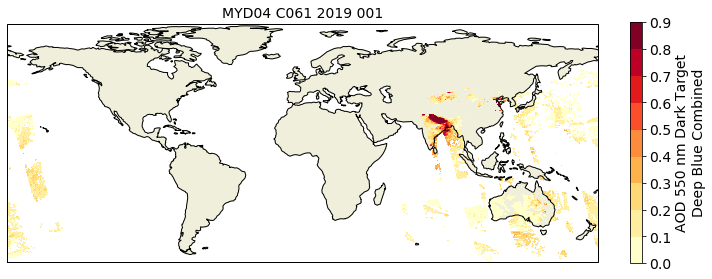

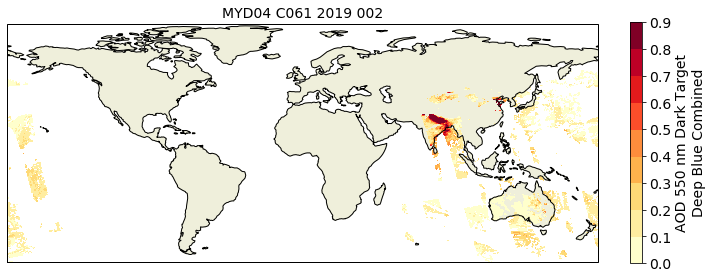

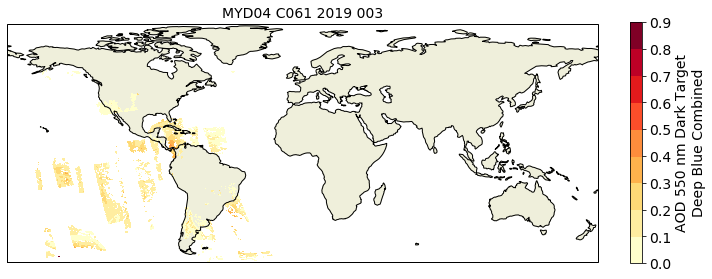

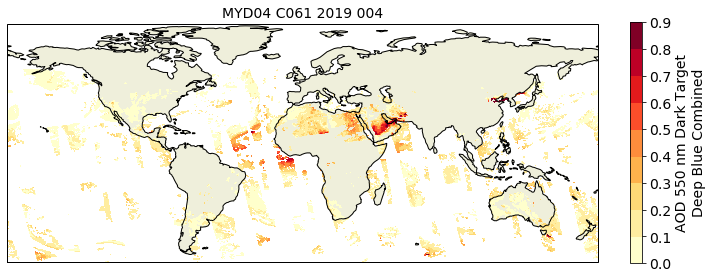

In [280]:
for julday in juldays:
    index = 0 
    hdf_files = []
    path = '/nfs/a336/earlacoa/modis/' + satellite + '.061/'
    hdf_files.extend(glob(path + satellite + '/' + year + '/' + julday + '/*hdf'))
    
    for file in hdf_files:
        reader = open(file)
        hdf_file = SD(file, SDC.READ)

        data_raw = hdf_file.select('AOD_550_Dark_Target_Deep_Blue_Combined')
        data = data_raw[:,:].astype(np.double)
        
        latitude = hdf_file.select('Latitude')[:,:]
        longitude = hdf_file.select('Longitude')[:,:]
        
        attributes = data_raw.attributes(full=1)
        add_offset = attributes["add_offset"][0]
        fill_value = attributes["_FillValue"][0]
        scale_factor = attributes["scale_factor"][0]      
        units = attributes["units"][0]

        data[data == fill_value] = np.nan
        data = (data - add_offset) * scale_factor 
        data_masked = np.ma.masked_array(data, np.isnan(data))
        
        if index == 0 :
            data_julday = data_masked
            latitude_julday = latitude
            longitude_julday = longitude
        else:
            data_julday = np.vstack([data_julday, data_masked])
            latitude_julday = np.vstack([latitude_julday, latitude])
            longitude_julday = np.vstack([longitude_julday, longitude])
        index += 1
        
    longitude_julday[longitude_julday == -999.0] = np.nan
    latitude_julday[latitude_julday == -999.0] = np.nan
    
    # swath setup
    swath_def = geometry.SwathDefinition(
        lons=longitude_julday,
        lats=latitude_julday
    )
    
    # swath resampling
    # - bilinear interpolation for irregular swath grids
    # - smoother results near swath edges
    result = bilinear.resample_bilinear(
        data_julday, 
        swath_def, 
        area_def, 
        radius=50e3, 
        neighbours=32,         
        nprocs=1, 
        fill_value=0, 
        reduce_data=True, 
        segments=None, 
        epsilon=0
    )
    
    result[result <= 0.0] = np.nan
    result = np.ma.masked_invalid(result)
    
    # create dataset for .nc
    ds = xr.DataArray(
        data = np.flipud(result), 
        coords = [global_reference_lat, global_reference_lon],
        dims = ['lat', 'lon']
    )
    ds.name = 'AOD'
    ds = ds.assign_coords({'time': datetime.strptime(year[-2:] + julday, '%y%j')})
    ds = ds.expand_dims('time')
    ds.to_netcdf(path + 'shared/nc_daily/' + satellite + '_C061_' + year + '_' + julday + '.nc')
    

    # plot
    aod = ds.values[0, :, :]
    xx, yy = np.meshgrid(ds.lon.values, ds.lat.values)
    plot_title = satellite[:-3] + ' C061 ' + year + ' ' + julday
    save_location = path + 'shared/png_daily/' + satellite + '_C061_' + year + '_' + julday + '.png'
    make_plot(xx, yy, aod, satellite, year, julday, plot_title, save_location)

### Create monthly and annual files

In [ ]:
year = '2019'
satellite = 'MYD04_L2' # 'MOD04_L2' / 'MYD04_L2'

In [168]:
months = ["%.2d" % month for month in range(1, 2)] #13
for month in months:
    days_in_month = monthrange(int(year), int(month))[1]
    julday_month_begins = datetime.strftime(datetime(int(year), int(month), 1), format='%j')
    julday_month_ends = datetime.strftime(datetime(int(year), int(month), int(days_in_month)), format='%j')
    juldays_in_month = ["%.3d" % julday for julday in range(int(julday_month_begins), int(julday_month_ends) + 1)]
    
    filelist = []
    for julday in juldays_in_month:
        filelist.extend(glob(path + 'shared/nc_daily/' + satellite + '_C061_' + year + '_' + julday + '.nc'))
        
    ds = xr.open_mfdataset(filelist, concat_dim='time', combine='by_coords')
    ds_mean = ds['AOD'].mean(dim='time')
    ds_mean.to_netcdf(path + 'shared/nc_monthly/' + satellite + '_C061_' + year + '_' + month + '.nc')
    
    aod = ds_mean.values[:, :]
    plot_title = satellite[:-3] + ' C061 ' + year + ' ' + month
    save_location = path + 'shared/png_monthly/' + satellite + '_C061_' + year + '_' + month + '.png'
    make_plot(xx, yy, aod, satellite, year, julday, plot_title, save_location)

/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


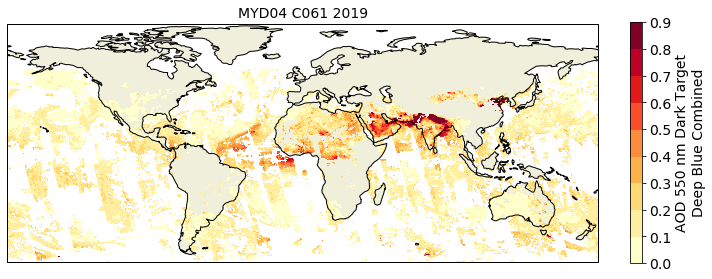

In [176]:
juldays_annual = ["%.3d" % julday for julday in range(days_begin, days_annual + 1)]
filelist = []
for julday in juldays_annual:
    filelist.extend(glob(path + 'shared/nc_daily/' + satellite + '_C061_' + year + '_' + julday + '.nc'))

ds = xr.open_mfdataset(filelist, concat_dim='time', combine='by_coords')
ds_mean = ds['AOD'].mean(dim='time')
ds_mean.to_netcdf(path + 'shared/nc_annual/' + satellite + '_C061_' + year + '.nc')

aod = ds_mean.values[:, :]
plot_title = satellite[:-3] + ' C061 ' + year
save_location = path + 'shared/png_annual/' + satellite + '_C061_' + year + '.png'
make_plot(xx, yy, aod, satellite, year, julday, plot_title, save_location)

### Merge (daily, monthly, and annual) data from both satellites

In [ ]:
year = '2019'
satellite = 'MYD04_L2' # 'MOD04_L2' / 'MYD04_L2'

In [302]:
def create_merged(year, interval, period):
    aqua_file  = xr.open_dataset(
        '/nfs/a336/earlacoa/modis/MYD04_L2.061/shared/nc_' + period + '/MYD04_L2_C061_' + year + '_' + interval + '.nc'
    )['AOD']
    terra_file = xr.open_dataset(
        '/nfs/a336/earlacoa/modis/MOD04_L2.061/shared/nc_' + period + '/MOD04_L2_C061_' + year + '_' + interval + '.nc'
    )['AOD']

    aqua_array = aqua_file.values[0, :, :]
    terra_array = terra_file.values[0, :, :]

    combined_stack = np.array([aqua_array, terra_array])
    combined = np.nanmean(combined_stack, axis=0)

    ds = xr.DataArray(
        data = combined, 
        coords = [aqua_file.lat, aqua_file.lon],
        dims = ['lat', 'lon']
    )
    ds.name = 'AOD'
    ds = ds.assign_coords({'time': datetime.strptime(year[-2:] + interval, '%y%j')})
    ds = ds.expand_dims('time')
    if interval == 'annual':
        ds.to_netcdf('/nfs/a336/earlacoa/modis/merged_files/nc_' + period + '/Merged_MOD_MYD_04_L2_C061_' + year + '.nc')
    else:
        ds.to_netcdf('/nfs/a336/earlacoa/modis/merged_files/nc_' + period + '/Merged_MOD_MYD_04_L2_C061_' + year + '_' + interval + '.nc')

/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


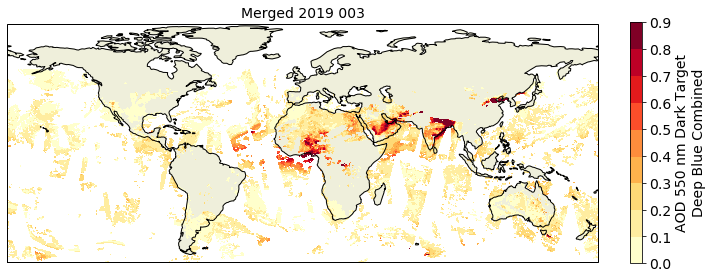

/nfs/a68/earlacoa/miniconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


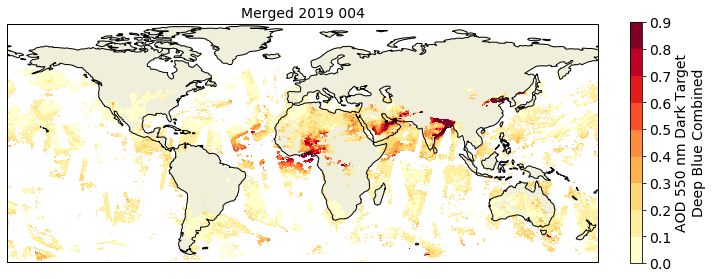

In [303]:
#juldays = ["%.3d" % julday for julday in range(3, days_annual + 1)] # terra has errorneous values for day 001 and 002
juldays = ["%.3d" % julday for julday in range(3, 4 + 1)] # terra has errorneous values for day 001 and 002

for julday in juldays:
    create_merged(year, julday, 'daily')

    plot_title = 'Merged ' + year + ' ' + julday
    save_location = '/nfs/a336/earlacoa/modis/merged_files/png_daily/Merged_MOD_MYD_04_L2_C061_' + year + '_' + julday + '.png'
    make_plot(xx, yy, combined, satellite, year, julday, plot_title, save_location)

In [ ]:
months = ["%.2d" % month for month in range(1, 2)] #13
for month in months:
    create_merged(year, month, 'monthly')

    plot_title = 'Merged ' + year + ' ' + julday
    save_location = '/nfs/a336/earlacoa/modis/merged_files/png_monthly/Merged_MOD_MYD_04_L2_C061_' + year + '_' + julday + '.png'
    make_plot(xx, yy, combined, satellite, year, julday, plot_title, save_location)

In [ ]:
create_merged(year, annual, 'annual')

plot_title = 'Merged ' + year + ' ' + julday
save_location = '/nfs/a336/earlacoa/modis/merged_files/png_annual/Merged_MOD_MYD_04_L2_C061_' + year + '.png'
make_plot(xx, yy, combined, satellite, year, julday, plot_title, save_location)